In [1]:
import pandas as pd

# animals_data.csv
with open('animals_data.csv', 'r', encoding='euc-kr', errors='replace') as f:
    animals_data = pd.read_csv(f, low_memory=False)

animals_data.to_csv('animals_data_utf8.csv', encoding='utf-8-sig', index=False)

# shelters_data.csv
with open('shelters_data.csv', 'r', encoding='euc-kr', errors='replace') as f:
    shelters_data = pd.read_csv(f, low_memory=False)

shelters_data.to_csv('shelters_data_utf8.csv', encoding='utf-8-sig', index=False)

In [2]:
animals_data = pd.read_csv('animals_data_utf8.csv', encoding='utf-8-sig')
shelters_data = pd.read_csv('shelters_data_utf8.csv', encoding='utf-8-sig')

print(animals_data.head(5))
print(shelters_data.head(5))

C:\Users\82103\AppData\Local\Temp\ipykernel_2408\2271769900.py:1: DtypeWarning: Columns (11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  animals_data = pd.read_csv('animals_data_utf8.csv', encoding='utf-8-sig')


   desertion_no shelter_name animal_name  species       age  \
0  4.485670e+14     창원동물보호센터  000114 (M)      114  2020(년생)   
1  4.485670e+14     창원동물보호센터  000114 (F)      114  2024(년생)   
2  4.485670e+14     창원동물보호센터  000114 (F)      114  2019(년생)   
3  4.485410e+14   창녕 유기동물보호소  000114 (M)      114  2020(년생)   
4  4.485410e+14   창녕 유기동물보호소  000114 (M)      114  2020(년생)   

                                           image_url personality  \
0  http://openapi.animal.go.kr/openapi/service/re...       정보 없음   
1  http://openapi.animal.go.kr/openapi/service/re...       정보 없음   
2  http://openapi.animal.go.kr/openapi/service/re...       정보 없음   
3  http://openapi.animal.go.kr/openapi/service/re...       정보 없음   
4  http://openapi.animal.go.kr/openapi/service/re...       정보 없음   

                             story notice_date sex process_state Unnamed: 11  \
0  검정색목줄착용.얼굴이 하운드계열 처럼 생겼음.잘 생 김.  2025-07-31   M           보호중         NaN   
1               내장칩 있어요~보호자분과 연락중~  2025-07-31   F  

In [3]:
# notice_date 날짜형 변환
animals_data['notice_date'] = pd.to_datetime(animals_data['notice_date'])

# 보호소 이름 기준으로 region 추가
df = animals_data.merge(
    shelters_data[['shelter_name', 'region']],
    on='shelter_name', how='left'
)

print(df[['notice_date','shelter_name','region']].head())

  notice_date shelter_name region
0  2025-07-31     창원동물보호센터   경상남도
1  2025-07-31     창원동물보호센터   경상남도
2  2025-07-31     창원동물보호센터   경상남도
3  2025-07-31     창원동물보호센터   경상남도
4  2025-07-31     창원동물보호센터   경상남도


In [4]:
daily_region = (
    df.groupby(['notice_date', 'region'])
      .size()
      .reset_index(name='count')
)

print(daily_region.head(10))

  notice_date region  count
0  2020-02-16   경상북도     43
1  2020-03-29   경상북도     43
2  2020-06-18   경상북도     43
3  2021-01-24   경상북도     43
4  2021-02-15   경상북도     43
5  2021-03-19   경상북도     43
6  2021-03-27   경상북도     43
7  2021-04-15   경상북도     43
8  2021-04-30   경상남도     43
9  2021-06-15   경상북도     43


In [5]:
pivot_df = daily_region.pivot(
    index='notice_date',
    columns='region',
    values='count'
).fillna(0)

print(pivot_df.head())

region       강원도  강원특별자치도  경기도  경상남도  경상북도  광주광역시  대구광역시  대전광역시  부산광역시  서울특별시  \
notice_date                                                                     
2020-02-16   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2020-03-29   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2020-06-18   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2021-01-24   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2021-02-15   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   

region       세종특별자치시  울산광역시  인천광역시  전라남도  전라북도  전북특별자치도  제주특별자치도  충청남도  충청북도  
notice_date                                                                   
2020-02-16       0.0    0.0    0.0   0.0   0.0      0.0      0.0   0.0   0.0  
2020-03-29       0.0    0.0    0.0   0.0   0.0      0.0      0.0   0.0   0.0  
2020-06-18       0.0    0.0    0.0   0.0   0.0      0.0      0.0   0.0   0.0  
2021-01-24       0.0    0.0    0.0   

In [6]:
pivot_features = pivot_df.copy()

# lag 1, lag 7
lag1 = pivot_df.shift(1).add_suffix('_lag1')
lag7 = pivot_df.shift(7).add_suffix('_lag7')

pivot_features = pd.concat([pivot_features, lag1, lag7], axis=1)

# rolling 평균 7일
rolling7 = pivot_df.rolling(7).mean().add_suffix('_rolling7')
pivot_features = pd.concat([pivot_features, rolling7], axis=1)

# 요일/주말 feature
pivot_features['weekday'] = pivot_features.index.weekday
pivot_features['is_weekend'] = pivot_features['weekday'].isin([5,6]).astype(int)

# NaN 제거
pivot_features = pivot_features.dropna()
print(pivot_features.head())

region       강원도  강원특별자치도  경기도  경상남도  경상북도  광주광역시  대구광역시  대전광역시  부산광역시  서울특별시  \
notice_date                                                                     
2021-04-15   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2021-04-30   0.0      0.0  0.0  43.0   0.0    0.0    0.0    0.0    0.0    0.0   
2021-06-15   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2021-08-19   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   
2021-09-23   0.0      0.0  0.0   0.0  43.0    0.0    0.0    0.0    0.0    0.0   

region       ...  울산광역시_rolling7  인천광역시_rolling7  전라남도_rolling7  \
notice_date  ...                                                  
2021-04-15   ...             0.0             0.0            0.0   
2021-04-30   ...             0.0             0.0            0.0   
2021-06-15   ...             0.0             0.0            0.0   
2021-08-19   ...             0.0             0.0            0.0   
2021-09-23   ...             0

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Feature: pivot_features (lag, rolling 포함)
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(pivot_features)

# Target: pivot_df (지역별 유기동물 수)
target = pivot_df.loc[pivot_features.index]  # feature index와 동일하게 맞춤
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(target)

print("Feature shape:", scaled_features.shape)
print("Target shape:", scaled_target.shape)  # (samples, 지역 수)

Feature shape: (1318, 78)
Target shape: (1318, 19)


In [8]:
time_steps = 30
X, y = [], []

for i in range(len(scaled_features) - time_steps):
    X.append(scaled_features[i:i+time_steps])      # 30일 feature
    y.append(scaled_target[i+time_steps])          # 다음 날 지역별 target 전체

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # (samples, time_steps, feature_dim)
print("y shape:", y.shape)  # (samples, 지역 수)

X shape: (1288, 30, 78)
y shape: (1288, 19)


In [9]:
split = int(len(X) * 0.9)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1159, 30, 78) (129, 30, 78) (1159, 19) (129, 19)


In [11]:
import optuna
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Attention 레이어는 기존 코드 그대로 사용
class Attention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Multi-output 출력 개수
n_outputs = y.shape[1]

# **Stacked Bi-LSTM + Attention 모델**
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),   # 1층 Bi-LSTM
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),    # 2층 Bi-LSTM
    Dropout(0.3),
    Attention(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_outputs)
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0426 - val_loss: 0.0218 - learning_rate: 5.0000e-04
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0286 - val_loss: 0.0185 - learning_rate: 5.0000e-04
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0261 - val_loss: 0.0179 - learning_rate: 5.0000e-04
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0238 - val_loss: 0.0180 - learning_rate: 5.0000e-04
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0246 - val_loss: 0.0176 - learning_rate: 5.0000e-04
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0223 - val_loss: 0.0178 - learning_rate: 5.0000e-04
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0229 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0223 - val_loss: 0.0170 - learning_rate: 5.0000e-04
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0221 - val_loss: 0.0166 - 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
최종 RMSE (지역 합계 기준): 3245.5967065745444


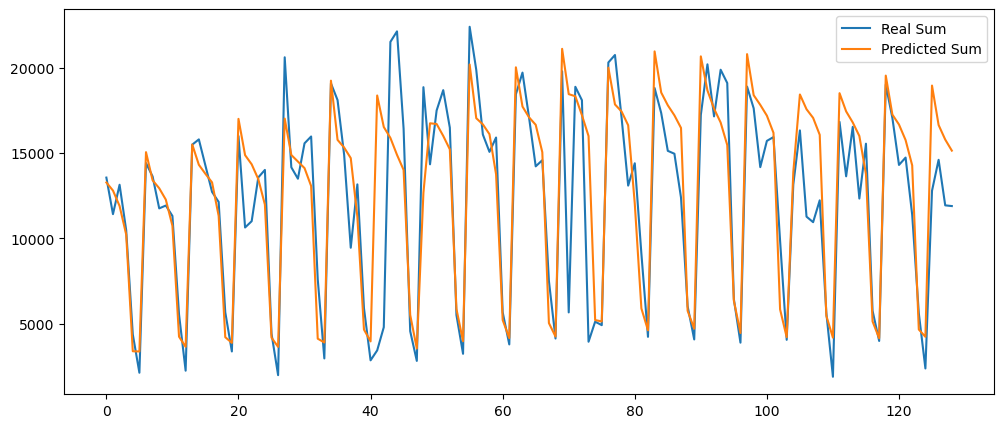

In [13]:
y_pred = model.predict(X_val)
y_pred = target_scaler.inverse_transform(y_pred)
y_val_real = target_scaler.inverse_transform(y_val)

real_sum = y_val_real.sum(axis=1)
pred_sum = y_pred.sum(axis=1)

from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

rmse = np.sqrt(mean_squared_error(real_sum, pred_sum))
print("최종 RMSE (지역 합계 기준):", rmse)

plt.figure(figsize=(12,5))
plt.plot(real_sum, label='Real Sum')
plt.plot(pred_sum, label='Predicted Sum')
plt.legend()
plt.show()

In [14]:
regions = list(pivot_df.columns)
for i, region in enumerate(regions):
    region_rmse = np.sqrt(mean_squared_error(y_val_real[:, i], y_pred[:, i]))
    print(f"{region}: {region_rmse:.2f}")

강원도: 311.33
강원특별자치도: 161.59
경기도: 971.95
경상남도: 471.72
경상북도: 419.37
광주광역시: 194.86
대구광역시: 306.20
대전광역시: 195.13
부산광역시: 429.40
서울특별시: 148.91
세종특별자치시: 70.30
울산광역시: 277.13
인천광역시: 354.89
전라남도: 581.16
전라북도: 328.00
전북특별자치도: 356.54
제주특별자치도: 327.14
충청남도: 446.88
충청북도: 342.08
